In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np

import random


from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator,PascalVOCDetectionEvaluator
import matplotlib.pyplot as plt
import torch.tensor as tensor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset
import torch
from detectron2.structures.instances import Instances
from detectron2.modeling import build_model
from detectron2.modeling.meta_arch.tracker import Tracker
from detectron2.modeling.meta_arch.soft_tracker import SoftTracker
%matplotlib inline






## Loading Weights

In [2]:
cfg = get_cfg()

cfg.merge_from_file("../configs/COCO-Detection/faster_rcnn_R_50_FPN_3x_Video.yaml")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set threshold for this model
cfg.MODEL.WEIGHTS = '/media/DATA/Users/Issa/models_pub/kitti_jde.pth'
#cfg.MODEL.WEIGHTS = "../models_pub/kitti_jde.pth"


print(cfg.MODEL)


WARNING [12/15 15:20:30 d2.config.compat]: Config '../configs/COCO-Detection/faster_rcnn_R_50_FPN_3x_Video.yaml' has no VERSION. Assuming it to be compatible with latest v2.
ANCHOR_GENERATOR:
  ANGLES: [[-90, 0, 90]]
  ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
  NAME: DefaultAnchorGenerator
  SIZES: [[32], [64], [128], [256], [512]]
BACKBONE:
  FREEZE_AT: 2
  NAME: build_resnet_fpn_backbone
DEVICE: cuda
FPN:
  FUSE_TYPE: sum
  IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
  NORM: 
  OUT_CHANNELS: 256
KEYPOINT_ON: False
LOAD_PROPOSALS: False
MASK_ON: False
META_ARCHITECTURE: VideoRCNN
PANOPTIC_FPN:
  COMBINE:
    ENABLED: True
    INSTANCES_CONFIDENCE_THRESH: 0.5
    OVERLAP_THRESH: 0.5
    STUFF_AREA_LIMIT: 4096
  INSTANCE_LOSS_WEIGHT: 1.0
PIXEL_MEAN: [103.53, 116.28, 123.675]
PIXEL_STD: [1.0, 1.0, 1.0]
PROPOSAL_GENERATOR:
  MIN_SIZE: 0
  NAME: RPN
RESNETS:
  DEFORM_MODULATED: False
  DEFORM_NUM_GROUPS: 1
  DEFORM_ON_PER_STAGE: [False, False, False, False]
  DEPTH: 50
  NORM: FrozenBN
  NUM_GRO

## functions to validate annotated data using devkit_tracking from KITTI

In [3]:
from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
def print_val_results(results_name):

    with suppress_stdout():
        print("Now you don't")
        os.system('python2 /home/issa/devkit_tracking/python/validate_tracking.py val')
    
    
    labels = {1:'MOTA',2:'MOTP',3:'MOTAL',4:'MODA',5:'MODP',7:'R',8:'P',12:'MT',13:'PT',14:'ML',18:'FP',19:'FN',22:'IDs'}
    summary_heading = 'Metric\t'
    for label in labels.keys():
        summary_heading+=labels[label] + '\t'
    summary_cars = 'Cars\t'
    summary_peds = 'Peds\t'
    with open('/home/issa/devkit_tracking/python/results/'+results_name+'/summary_car.txt') as f:
        i=0
        for line in f:
            if(i==0):
                i+=1
                continue
            if(i in labels.keys()):
                summary_cars+= str(round(float(line[len(line)-9:len(line)-1].strip()),2))+'\t'
            i+=1


  
    print(summary_heading)
    print(summary_cars)
    
def print_test_results(results_name):

    #with suppress_stdout():
    print("Now you don't")
    os.system('python2 ../devkit_tracking/python/evaluate_tracking.py test')
    
    
    labels = {1:'MOTA',2:'MOTP',3:'MOTAL',4:'MODA',5:'MODP',7:'R',8:'P',12:'MT',13:'PT',14:'ML',18:'FP',19:'FN',22:'IDs'}
    summary_heading = 'Metric\t'
    for label in labels.keys():
        summary_heading+=labels[label] + '\t'
    summary_cars = 'Cars\t'
    summary_peds = 'Peds\t'
    with open('../devkit_tracking/python/results/'+results_name+'/summary_car.txt') as f:
        i=0
        for line in f:
            if(i==0):
                i+=1
                continue
            if(i in labels.keys()):
                summary_cars+= str(round(float(line[len(line)-9:len(line)-1].strip()),2))+'\t'
            i+=1


   
    print(summary_heading)
    print(summary_cars)
   

    



## Inference : Joint Detection and Tracking

In [5]:
import json
import os
import cv2 as cv2
import time
from tqdm.notebook import tqdm
colors = [[0,0,128],[0,255,0],[0,0,255],[255,0,0],[0,128,128],[128,0,128],[128,128,0],[255,255,0],[0,255,255],[255,255,0],[128,0,0],[0,128,0]
         ,[0,128,255],[0,255,128],[255,0,128],[128,255,0],[255,128,0],[128,255,255],[128,0,255],[128,128,128],[128,255,128]]
#dirC = '/../datasets/KITTI/tracking/data_tracking_image_2/training/image_02/'
dirC = '/media/DATA/Datasets/KITTI/tracking/data_tracking_image_2/training/image_02/'
#dirDets = '../datasets/KITTI/tracking/data_tracking_det_2_lsvm/training/det_02/'
names = []
arr = {2:'Car'}
#if(not os.path.exists("../results")):
    #os.mkdir('../results')
    #os.mkdir('../results/KITTI')
#else:
    #if(not os.path.exists("../results/KITTI")):
        #os.mkdir('../results/KITTI')
#output_path = '../results/KITTI'
if(not os.path.exists("../results")):
    os.mkdir('../results')
    os.mkdir('../results/KITTI')
else:
    if(not os.path.exists("../results/KITTI")):
        os.mkdir('../results/KITTI')
output_path = '/home/issa/devkit_tracking/python/results'
settings = [
   
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.75
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.8
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.85
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.9
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.95
        ),
   

]
train_folders = ['0000','0002','0003','0004','0005','0009','0011','0017','0020']
val_folders = ['0001','0006','0008','0016','0018','0019']
test_folders = ['0014','0015','0016','0018','0019','0001','0006','0008','0010','0012','0013']
submission_folders = ['0000','0001','0002','0003','0004','0005','0006','0007',
                      '0008','0009','0010','0011','0012','0013','0014','0015','0016','0017',
                      '0018','0019','0020','0021','0022','0023','0024','0025','0026','0027','0028']
final_test_folders = ['0014']
for setting in settings:
    test_name = 'val'
    exp_name = output_path+ '/'+test_name
    
    if(not os.path.exists(exp_name)):
      os.mkdir(exp_name)
      os.mkdir(exp_name+'/data')
    avg=0
    for folder_name in val_folders:
      dets = {}
      public_det=False
      if public_det==True:
          with open(dirDets+folder_name+'.txt') as det_file:
            for line in det_file:
              parts = line.split(' ')

              if(parts[0] not in dets):
                dets[parts[0]] = []
              if(parts[2] =='Car' and float(parts[17])>-1):

                dets[parts[0]].append([float(parts[6])
                                     ,float(parts[7]),float(parts[8]) 
                                     ,float(parts[9]),float(parts[6]),float(parts[17])])

      predictor = DefaultPredictor(cfg,True)
      predictor.model.tracker = Tracker()
      predictor.model.tracking_proposals = setting['T']
      predictor.model.tracker.track_life = setting['track_life']
      predictor.model.tracker.track_visibility = setting['track_vis']
      predictor.model.tracker.use_appearance = setting['A']
      predictor.model.tracker.use_kalman = setting['K']
      predictor.model.tracker.hot = setting['H']
      predictor.model.tracker.embed = setting['E']
      predictor.model.tracker.reid = setting['Re']
      predictor.model.tracker.hog = setting['H']
      predictor.model.tracker.dist = setting['D']
      predictor.model.tracker.measurement_noise=setting['measurement']
      predictor.model.tracker.process_noise = setting['process']
      predictor.model.tracker.hog_num_cells = setting['hog_cells']
      predictor.model.tracker.dist_thresh = setting['dist_thresh']
      predictor.model.use_reid = setting['Re']
      predictor.model.tracker.giou_cutoff = setting['giou_cutoff']
      predictor.model.tracker.soft_thresh = setting['st']
      predictor.model.tracker.suppress_fp = setting['sup_fp']
      predictor.model.tracker.fp_thresh = setting['fp_thresh']
      predictor.model.tracker.embed_alpha = setting['alpha']
      max_distance = 0.2
      
      
      
        
      output_file = open('%s/data/%s.txt'%(exp_name,folder_name),'w')
      
      frames = {}
      frame_counter = 0
      prev_path = 0
      elapsed = 0
      predictor.model.prev_path = 0
      for photo_name in sorted(os.listdir(dirC+folder_name+'/')):
        frames[frame_counter] = {}
        img_path = dirC+folder_name+'/'+photo_name
        img = cv2.imread(img_path)
        inp = {}
        inp['width'] = img.shape[1]
        inp['height'] = img.shape[0]

        

        inp['file_name'] =  photo_name
        inp['image_id'] = photo_name
       
        predictor.model.photo_name = img_path
        start = time.time()
        outputs = predictor(img,setting['props'])
        end = time.time()
        elapsed +=(end-start)
       
        for i in outputs:
          
    
          if(i.pred_class in arr):
              output_file.write("%d %d %s 0 0 -0.20 %d %d %d %d 1.89 0.48 1.20 1.84 1.47 8.41 0.01 %f\n"%(frame_counter
                                                                                                             ,i.track_id,arr[i.pred_class],i.xmin,i.ymin,i.xmax,i.ymax,i.conf))
        
        frame_counter +=1
        predictor.model.prev_path = img_path
      
      avg += (frame_counter/elapsed)
        
      output_file.close()
      
    print(setting)
    print('avg_time :',avg/len(val_folders))
    print_val_results(test_name)

          

{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 'A': True, 'H': False, 'K': True, 'E': False, 'measurement': 0.001, 'process': 1, 'hog_cells': 4, 'dist_thresh': 1.5, 'track_life': 7, 'track_vis': 2, 'giou_cutoff': -0.75}
avg_time : 13.372975970794842
Metric	MOTA	MOTP	MOTAL	MODA	MODP	R	P	MT	PT	ML	FP	FN	IDs	
Cars	0.76	0.8	0.77	0.77	0.84	0.9	0.91	0.75	0.23	0.02	733.0	786.0	49.0	
{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 'A': True, 'H': False, 'K': True, 'E': False, 'measurement': 0.001, 'process': 1, 'hog_cells': 4, 'dist_thresh': 1.5, 'track_life': 7, 'track_vis': 2, 'giou_cutoff': -0.8}
avg_time : 13.321391622780654
Metric	MOTA	MOTP	MOTAL	MODA	MODP	R	P	MT	PT	ML	FP	FN	IDs	
Cars	0.77	0.8	0.78	0.78	0.84	0.9	0.91	0.73	0.25	0.02	697.0	782.0	52.0	
{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 

In [6]:
import json
import os
import cv2 as cv2
import time
from tqdm.notebook import tqdm
colors = [[0,0,128],[0,255,0],[0,0,255],[255,0,0],[0,128,128],[128,0,128],[128,128,0],[255,255,0],[0,255,255],[255,255,0],[128,0,0],[0,128,0]
         ,[0,128,255],[0,255,128],[255,0,128],[128,255,0],[255,128,0],[128,255,255],[128,0,255],[128,128,128],[128,255,128]]
#dirC = '/../datasets/KITTI/tracking/data_tracking_image_2/training/image_02/'
dirC = '/media/DATA/Datasets/KITTI/tracking/data_tracking_image_2/training/image_02/'
#dirDets = '../datasets/KITTI/tracking/data_tracking_det_2_lsvm/training/det_02/'
names = []
arr = {2:'Car'}
#if(not os.path.exists("../results")):
    #os.mkdir('../results')
    #os.mkdir('../results/KITTI')
#else:
    #if(not os.path.exists("../results/KITTI")):
        #os.mkdir('../results/KITTI')
#output_path = '../results/KITTI'
if(not os.path.exists("../results")):
    os.mkdir('../results')
    os.mkdir('../results/KITTI')
else:
    if(not os.path.exists("../results/KITTI")):
        os.mkdir('../results/KITTI')
output_path = '/home/issa/devkit_tracking/python/results'
settings = [
   
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.3
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.4
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.5
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.6
        ),
    dict(props=20, #number of proposals to use by rpn
         st=1.05, #acceptance distance percentage for soft tracker
         sup_fp = True, # fp suppression based on Intersection over Union for new detections
         alpha = 0.6, # the percentage of the new embedding in track embedding update (emb = alpha * emb(t) +(1-alpha) emb(t-1)) 
         fp_thresh=0.95, # iou threshold above which the new detection is considered a fp
         T=True, #use past tracks as proposals
         D='cosine', # distance metric for embeddings
         Re=True, #use the embedding head 
         A=True, # use appearance information
         H=False, # use HOG features as appearance descriptors
         K=True, # use kalman for motion prediction
         E=False, #use raw FPN features as appearance descriptors
         measurement=0.001, #measruement noise for the kalman filter
         process=1, #process noise for the kalman filter
         hog_cells=4, #number of cells used to calculate hof features
         dist_thresh=1.5, # the normalization factor for the appearance distance
         track_life=7, #frames for which a track is kept in memory without an update
         track_vis=2, #frames for which a track is displayed without an update
         giou_cutoff=-0.7
        ),
   

]
train_folders = ['0000','0002','0003','0004','0005','0009','0011','0017','0020']
val_folders = ['0001','0006','0008','0016','0018','0019']
test_folders = ['0014','0015','0016','0018','0019','0001','0006','0008','0010','0012','0013']
submission_folders = ['0000','0001','0002','0003','0004','0005','0006','0007',
                      '0008','0009','0010','0011','0012','0013','0014','0015','0016','0017',
                      '0018','0019','0020','0021','0022','0023','0024','0025','0026','0027','0028']
final_test_folders = ['0014']
for setting in settings:
    test_name = 'val'
    exp_name = output_path+ '/'+test_name
    
    if(not os.path.exists(exp_name)):
      os.mkdir(exp_name)
      os.mkdir(exp_name+'/data')
    avg=0
    for folder_name in val_folders:
      dets = {}
      public_det=False
      if public_det==True:
          with open(dirDets+folder_name+'.txt') as det_file:
            for line in det_file:
              parts = line.split(' ')

              if(parts[0] not in dets):
                dets[parts[0]] = []
              if(parts[2] =='Car' and float(parts[17])>-1):

                dets[parts[0]].append([float(parts[6])
                                     ,float(parts[7]),float(parts[8]) 
                                     ,float(parts[9]),float(parts[6]),float(parts[17])])

      predictor = DefaultPredictor(cfg,True)
      predictor.model.tracker = Tracker()
      predictor.model.tracking_proposals = setting['T']
      predictor.model.tracker.track_life = setting['track_life']
      predictor.model.tracker.track_visibility = setting['track_vis']
      predictor.model.tracker.use_appearance = setting['A']
      predictor.model.tracker.use_kalman = setting['K']
      predictor.model.tracker.hot = setting['H']
      predictor.model.tracker.embed = setting['E']
      predictor.model.tracker.reid = setting['Re']
      predictor.model.tracker.hog = setting['H']
      predictor.model.tracker.dist = setting['D']
      predictor.model.tracker.measurement_noise=setting['measurement']
      predictor.model.tracker.process_noise = setting['process']
      predictor.model.tracker.hog_num_cells = setting['hog_cells']
      predictor.model.tracker.dist_thresh = setting['dist_thresh']
      predictor.model.use_reid = setting['Re']
      predictor.model.tracker.giou_cutoff = setting['giou_cutoff']
      predictor.model.tracker.soft_thresh = setting['st']
      predictor.model.tracker.suppress_fp = setting['sup_fp']
      predictor.model.tracker.fp_thresh = setting['fp_thresh']
      predictor.model.tracker.embed_alpha = setting['alpha']
      max_distance = 0.2
      
      
      
        
      output_file = open('%s/data/%s.txt'%(exp_name,folder_name),'w')
      
      frames = {}
      frame_counter = 0
      prev_path = 0
      elapsed = 0
      predictor.model.prev_path = 0
      for photo_name in sorted(os.listdir(dirC+folder_name+'/')):
        frames[frame_counter] = {}
        img_path = dirC+folder_name+'/'+photo_name
        img = cv2.imread(img_path)
        inp = {}
        inp['width'] = img.shape[1]
        inp['height'] = img.shape[0]

        

        inp['file_name'] =  photo_name
        inp['image_id'] = photo_name
       
        predictor.model.photo_name = img_path
        start = time.time()
        outputs = predictor(img,setting['props'])
        end = time.time()
        elapsed +=(end-start)
       
        for i in outputs:
          
    
          if(i.pred_class in arr):
              output_file.write("%d %d %s 0 0 -0.20 %d %d %d %d 1.89 0.48 1.20 1.84 1.47 8.41 0.01 %f\n"%(frame_counter
                                                                                                             ,i.track_id,arr[i.pred_class],i.xmin,i.ymin,i.xmax,i.ymax,i.conf))
        
        frame_counter +=1
        predictor.model.prev_path = img_path
      
      avg += (frame_counter/elapsed)
        
      output_file.close()
      
    print(setting)
    print('avg_time :',avg/len(val_folders))
    print_val_results(test_name)

          

{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 'A': True, 'H': False, 'K': True, 'E': False, 'measurement': 0.001, 'process': 1, 'hog_cells': 4, 'dist_thresh': 1.5, 'track_life': 7, 'track_vis': 2, 'giou_cutoff': -0.3}
avg_time : 13.45391001578681
Metric	MOTA	MOTP	MOTAL	MODA	MODP	R	P	MT	PT	ML	FP	FN	IDs	
Cars	0.76	0.8	0.77	0.77	0.84	0.9	0.9	0.75	0.23	0.02	753.0	756.0	69.0	
{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 'A': True, 'H': False, 'K': True, 'E': False, 'measurement': 0.001, 'process': 1, 'hog_cells': 4, 'dist_thresh': 1.5, 'track_life': 7, 'track_vis': 2, 'giou_cutoff': -0.4}
avg_time : 13.338093495496851
Metric	MOTA	MOTP	MOTAL	MODA	MODP	R	P	MT	PT	ML	FP	FN	IDs	
Cars	0.77	0.81	0.78	0.78	0.84	0.9	0.91	0.75	0.23	0.03	711.0	783.0	67.0	
{'props': 20, 'st': 1.05, 'sup_fp': True, 'alpha': 0.6, 'fp_thresh': 0.95, 'T': True, 'D': 'cosine', 'Re': True, 'A

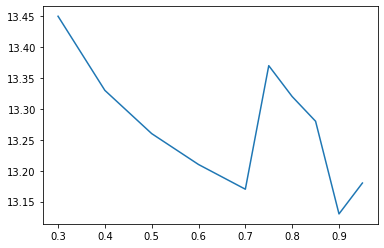

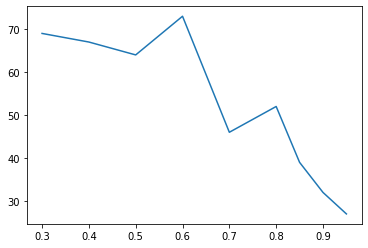

In [8]:
x = [0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95]
y_1 = [13.45,13.33,13.26,13.21,13.17,13.37,13.32,13.28,13.13,13.18]
y_2 = [69,67,64,73,46,49,52,39,32,27]
plt.plot(x,y_1)
plt.figure()
plt.plot(x,y_2)